# Imports

In [51]:
from google.colab import drive
drive.mount('/content/drive')

import numpy as np
import pandas as pd
pd.options.display.max_columns = 200

import matplotlib.pyplot as plt
from matplotlib.pyplot import axis
from matplotlib.pyplot import imshow
from matplotlib.pyplot import subplots
plt.style.use('ggplot')
import seaborn as sns

import re
from tqdm.notebook import tqdm
tqdm.pandas()
import pickle

import spacy
import nltk
nltk.download('punkt')
nltk.download('words')
nltk.download('stopwords')
nltk.download('vader_lexicon')
from nltk.corpus import stopwords
from nltk.sentiment import SentimentIntensityAnalyzer

from sklearn.feature_extraction.text import TfidfVectorizer

from wordcloud import WordCloud
from wordcloud import STOPWORDS

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


In [2]:
df = pd.read_csv('/content/drive/MyDrive/IHFP/dataset/steam_reviews.csv')
df.head()

<ipython-input-2-c5560186433e>:1: DtypeWarning: Columns (17) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv('/content/drive/MyDrive/IHFP/dataset/steam_reviews.csv')


,Unnamed: 0,app_id,app_name,review_id,language,review_text,voted_up,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china,steam_china_location
0,0,2397380,The Cold Hand,138284361,english,"""Yeah man, I'm making a game. It's gonna be a ...",False,2023-05-14 10:54:21,2023-05-16 09:14:07,3,0,0.552239,0,False,False,False,True,NaN
1,1,2397380,The Cold Hand,137869845,english,I like the part where you jump on enemies and ...,True,2023-05-06 08:16:29,2023-05-06 08:16:29,2,0,0.531250,0,False,False,False,True,NaN
2,2,2397380,The Cold Hand,137856344,japanese,[h1]やたらとエンディングはある[/h1]\n死んだ時にびっくり要素があるので最初だけ注意...,True,2023-05-06 01:13:49,2023-05-06 01:14:34,1,0,0.508197,0,False,False,False,True,NaN
3,3,2397400,Unnatural Season Two,137882379,english,"To be perfectly honest, it ends up feeling lik...",False,2023-05-06 13:30:52,2023-05-06 23:01:36,12,0,0.671914,0,True,False,False,True,NaN
4,4,2397400,Unnatural Season Two,138491433,english,"Didn't know this was planned as a series, so h...",True,2023-05-18 14:34:00,2023-05-18 14:34:00,1,0,0.521739,0,True,False,False,True,NaN


# Data Exploration

## Basic overview

- Dataset contains 370,000 user reviews across 36,000 games/apps

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 369878 entries, 0 to 369877
Data columns (total 18 columns):
 #   Column                       Non-Null Count   Dtype  
---  ------                       --------------   -----  
 0   Unnamed: 0                   369878 non-null  int64  
 1   app_id                       369878 non-null  int64  
 2   app_name                     369878 non-null  object 
 3   review_id                    369878 non-null  int64  
 4   language                     369878 non-null  object 
 5   review_text                  369696 non-null  object 
 6   voted_up                     369878 non-null  bool   
 7   timestamp_created            369878 non-null  object 
 8   timestamp_updated            369878 non-null  object 
 9   votes_up                     369878 non-null  int64  
 10  votes_funny                  369878 non-null  int64  
 11  weighted_vote_score          369878 non-null  float64
 12  comment_count                369878 non-null  int64  
 13 

In [4]:
print('Number of unique apps:', df['app_name'].nunique())

Number of unique apps: 36413


- Rating system: Recommended / Not Recommended

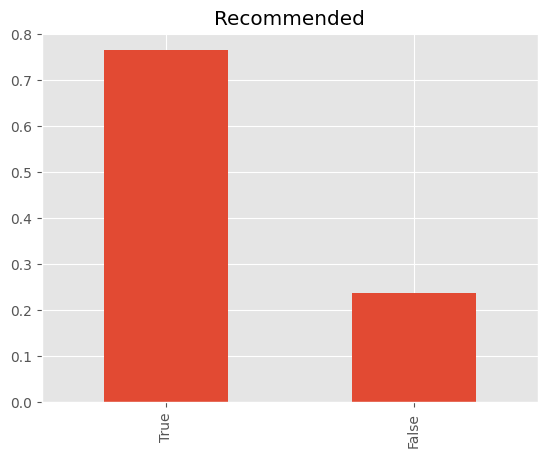

True     282425
False     87453
Name: voted_up, dtype: int64


In [5]:
df['voted_up'].value_counts(normalize=True).plot(kind='bar', title="Recommended")
plt.show()
print(df['voted_up'].value_counts())

- 29 languages (51% English, 16% Chinese, 8% Russian, 25% other)
- Published between 2019 and 2023

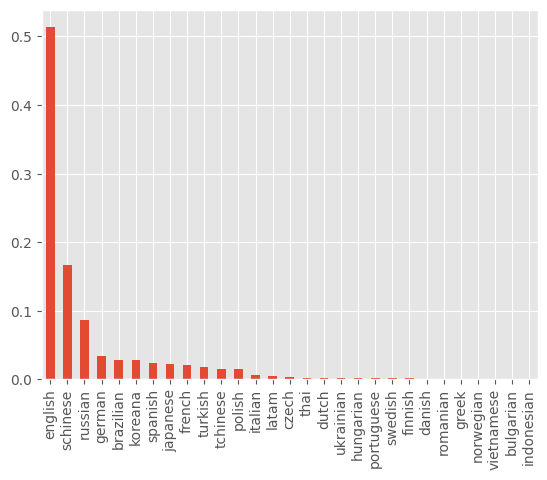

Number of languages: 29


english      0.513626
schinese     0.167261
russian      0.086677
german       0.033492
brazilian    0.028188
Name: language, dtype: float64

In [6]:
df['language'].value_counts(normalize=True).plot(kind='bar')
plt.show()
print('Number of languages:', df['language'].nunique())
df['language'].value_counts(normalize=True).head()

<Axes: >

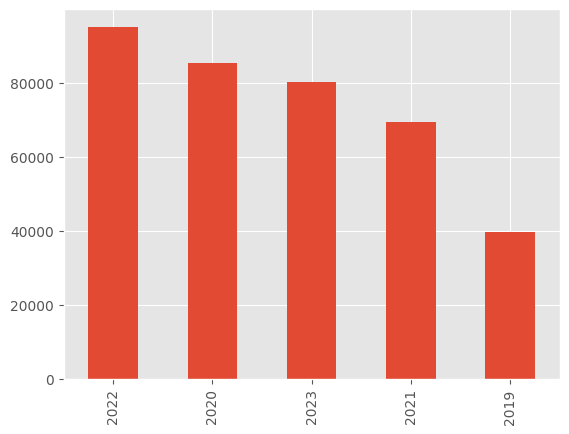

In [7]:
pd.to_datetime(df['timestamp_created']).dt.year.value_counts().plot(kind='bar')

## Data cleaning

In [8]:
df_to_clean = df.copy()

In [9]:
df_to_clean.drop(['Unnamed: 0','steam_china_location'], axis=1, inplace=True)
df_to_clean.columns

Index(['app_id', 'app_name', 'review_id', 'language', 'review_text',
       'voted_up', 'timestamp_created', 'timestamp_updated', 'votes_up',
       'votes_funny', 'weighted_vote_score', 'comment_count', 'steam_purchase',
       'received_for_free', 'written_during_early_access',
       'hidden_in_steam_china'],
      dtype='object')

In [10]:
df_to_clean['timestamp_created'] = pd.to_datetime(df_to_clean['timestamp_created'])
df_to_clean['timestamp_updated'] = pd.to_datetime(df_to_clean['timestamp_updated'])
df_to_clean.dtypes

app_id                                  int64
app_name                               object
review_id                               int64
language                               object
review_text                            object
voted_up                                 bool
timestamp_created              datetime64[ns]
timestamp_updated              datetime64[ns]
votes_up                                int64
votes_funny                             int64
weighted_vote_score                   float64
comment_count                           int64
steam_purchase                           bool
received_for_free                        bool
written_during_early_access              bool
hidden_in_steam_china                    bool
dtype: object

In [11]:
df_to_clean.isna().sum()

app_id                           0
app_name                         0
review_id                        0
language                         0
review_text                    182
voted_up                         0
timestamp_created                0
timestamp_updated                0
votes_up                         0
votes_funny                      0
weighted_vote_score              0
comment_count                    0
steam_purchase                   0
received_for_free                0
written_during_early_access      0
hidden_in_steam_china            0
dtype: int64

In [12]:
df_to_clean.duplicated().value_counts()

False    369878
dtype: int64

In [13]:
df_to_clean.duplicated(subset=['review_id']).value_counts()

False    369869
True          9
dtype: int64

In [14]:
df_to_clean = df_to_clean.loc[~df.duplicated(subset=['review_id'])]
df_to_clean.duplicated(subset=['review_id']).value_counts()

False    369869
dtype: int64

In [15]:
df_clean = df_to_clean.reset_index(drop=True)
df_clean

,app_id,app_name,review_id,language,review_text,voted_up,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access,hidden_in_steam_china
0,2397380,The Cold Hand,138284361,english,"""Yeah man, I'm making a game. It's gonna be a ...",False,2023-05-14 10:54:21,2023-05-16 09:14:07,3,0,0.552239,0,False,False,False,True
1,2397380,The Cold Hand,137869845,english,I like the part where you jump on enemies and ...,True,2023-05-06 08:16:29,2023-05-06 08:16:29,2,0,0.531250,0,False,False,False,True
2,2397380,The Cold Hand,137856344,japanese,[h1]やたらとエンディングはある[/h1]\n死んだ時にびっくり要素があるので最初だけ注意...,True,2023-05-06 01:13:49,2023-05-06 01:14:34,1,0,0.508197,0,False,False,False,True
3,2397400,Unnatural Season Two,137882379,english,"To be perfectly honest, it ends up feeling lik...",False,2023-05-06 13:30:52,2023-05-06 23:01:36,12,0,0.671914,0,True,False,False,True
4,2397400,Unnatural Season Two,138491433,english,"Didn't know this was planned as a series, so h...",True,2023-05-18 14:34:00,2023-05-18 14:34:00,1,0,0.521739,0,True,False,False,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
369864,1442220,Virtual Happiness: 18+ Content (Uncensored),136156170,english,⠄⣾⣿⠿⠿⠶⠿⢿⣿⣿⣿⣿⣦⣤⣄⢀⡅⢠⣾⣛⡉⠄⠄⠄⠸⢀⣿⠄\n⢀⡋⣡⣴⣶⣶⡀⠄⠄⠙⢿⣿⣿⣿⣿⣿...,True,2023-04-05 15:32:26,2023-04-05 15:32:26,0,0,0.000000,0,False,False,False,True
369865,1442260,Filmmaker Tycoon Demo,77400893,english,I know its just a demo....but damn the game is...,False,2020-10-11 15:21:16,2020-10-11 15:21:16,0,0,0.000000,0,False,False,False,False
369866,1442280,Star Conflict - Starter Pack. Pterosaur,113240418,english,I like the module on this ship.,True,2022-04-02 20:39:28,2022-04-02 20:39:28,1,0,0.523810,0,True,False,False,False
369867,1442281,Star Conflict - Starter Pack. Dainsleif,113240360,english,Starter +,True,2022-04-02 20:37:55,2022-04-02 20:37:55,1,0,0.507154,0,True,False,False,False


# Feature selection for english language

- English only: 190,000 reviews on 28,000 games
- Feature Selection for NLP:
  - review_text, app_name, language[English], voted_up(Recommendation)

In [16]:
df_en = df_clean[df_clean['language'] == 'english'].copy()
df_en.drop(['language','hidden_in_steam_china'], axis=1, inplace=True)
df_en.reset_index(drop=True, inplace=True)
df_en.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189973 entries, 0 to 189972
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   app_id                       189973 non-null  int64         
 1   app_name                     189973 non-null  object        
 2   review_id                    189973 non-null  int64         
 3   review_text                  189876 non-null  object        
 4   voted_up                     189973 non-null  bool          
 5   timestamp_created            189973 non-null  datetime64[ns]
 6   timestamp_updated            189973 non-null  datetime64[ns]
 7   votes_up                     189973 non-null  int64         
 8   votes_funny                  189973 non-null  int64         
 9   weighted_vote_score          189973 non-null  float64       
 10  comment_count                189973 non-null  int64         
 11  steam_purchase            

## Visualizations

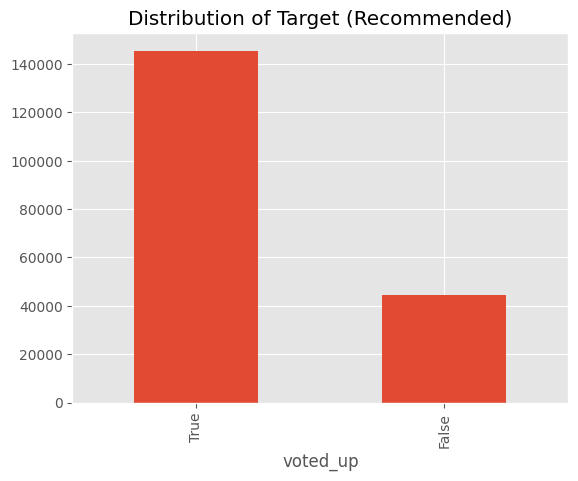

In [17]:
ax = df_en['voted_up'].value_counts().plot(kind='bar', title='Distribution of Target (Recommended)')
ax.set_xlabel('voted_up')
plt.show()

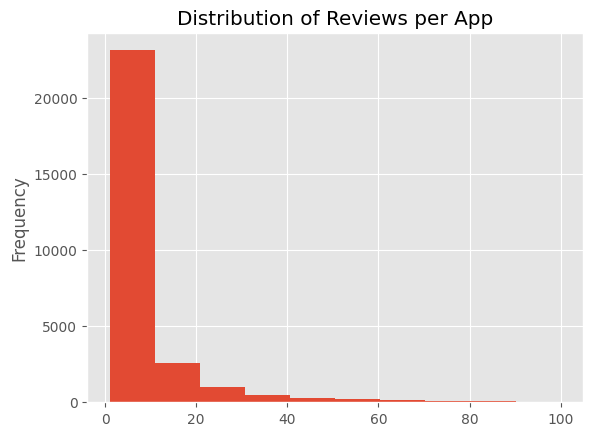

Number of apps: 27940


In [18]:
df_en['app_name'].value_counts().plot(kind='hist',title='Distribution of Reviews per App')
plt.show()
print('Number of apps:', df_en['app_name'].nunique())

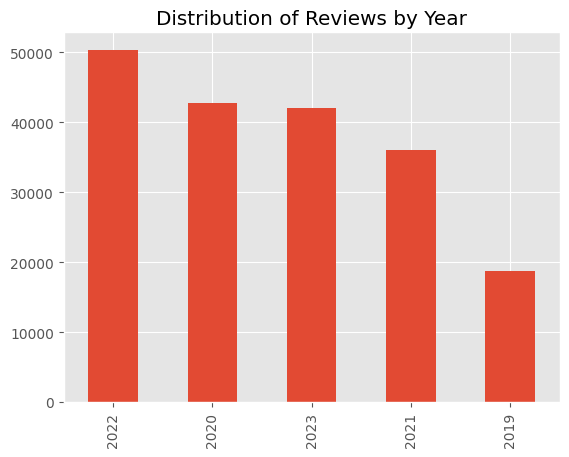

In [19]:
df_en['timestamp_created'].dt.year.value_counts().plot(kind='bar', title='Distribution of Reviews by Year')
plt.show()

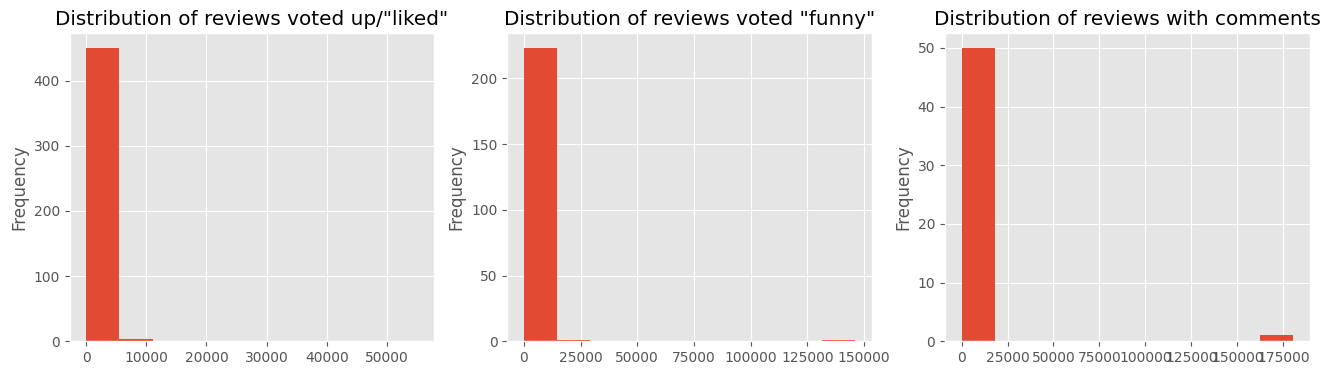

In [20]:
ax1 = df_en['votes_up'].value_counts()
ax2 = df_en['votes_funny'].value_counts()
ax3 = df_en['comment_count'].value_counts()

fig, axes = plt.subplots(1, 3, figsize=(16, 4))

ax1.plot(ax=axes[0],kind='hist',title='Distribution of reviews voted up/"liked"')
ax2.plot(ax=axes[1],kind='hist',title='Distribution of reviews voted "funny"')
ax3.plot(ax=axes[2],kind='hist',title='Distribution of reviews with comments')

plt.show()

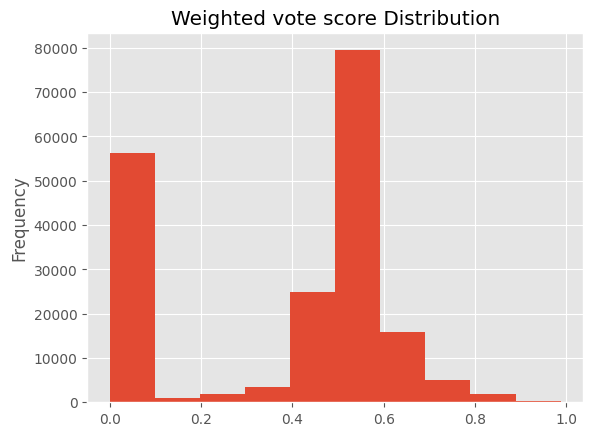

In [21]:
df_en['weighted_vote_score'].plot(kind='hist', title="Weighted vote score Distribution")
plt.show()

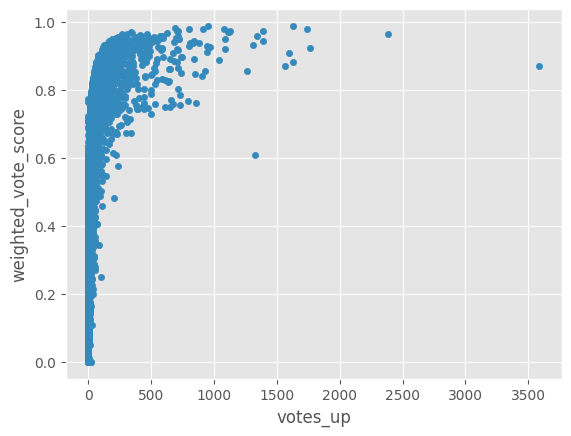

In [22]:
df_en.plot(kind='scatter', x='votes_up',y='weighted_vote_score')
plt.show()

# Text Pre-Processing


In [23]:
df_en_pp = df_en.copy()
df_en_pp.reset_index(drop=True, inplace=True)
df_en_pp.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 189973 entries, 0 to 189972
Data columns (total 14 columns):
 #   Column                       Non-Null Count   Dtype         
---  ------                       --------------   -----         
 0   app_id                       189973 non-null  int64         
 1   app_name                     189973 non-null  object        
 2   review_id                    189973 non-null  int64         
 3   review_text                  189876 non-null  object        
 4   voted_up                     189973 non-null  bool          
 5   timestamp_created            189973 non-null  datetime64[ns]
 6   timestamp_updated            189973 non-null  datetime64[ns]
 7   votes_up                     189973 non-null  int64         
 8   votes_funny                  189973 non-null  int64         
 9   weighted_vote_score          189973 non-null  float64       
 10  comment_count                189973 non-null  int64         
 11  steam_purchase            

## Cleaning

- Removing Nans

In [25]:
df_en_pp.isna().sum()

app_id                          0
app_name                        0
review_id                       0
review_text                    97
voted_up                        0
timestamp_created               0
timestamp_updated               0
votes_up                        0
votes_funny                     0
weighted_vote_score             0
comment_count                   0
steam_purchase                  0
received_for_free               0
written_during_early_access     0
dtype: int64

In [26]:
df_en_pp.dropna(inplace=True)
df_en_pp.isna().sum()

app_id                         0
app_name                       0
review_id                      0
review_text                    0
voted_up                       0
timestamp_created              0
timestamp_updated              0
votes_up                       0
votes_funny                    0
weighted_vote_score            0
comment_count                  0
steam_purchase                 0
received_for_free              0
written_during_early_access    0
dtype: int64

In [27]:
df_en_pp.shape

(189876, 14)

- Regex (cleaning empty/meaningless text, html tags, ascii art)

In [29]:
def re_pattern_filter(df, patterns):
  for pat in patterns:
    filtered = df['review_text'].str.contains(pat)
    df = df[~filtered]
    return df

In [30]:
re_patterns = ["^\s+$", "^\.+$", "^[!\?:\.\\<\|{}>_&%]$", "^\W{6,}$", "^\-+$", "^[^w|W]$", "\[?/.+\]"]

df_en_pp = re_pattern_filter(df_en_pp, re_patterns)
df_en_pp.shape

(189861, 14)

## Lemmatization

In [ ]:
nlp = spacy.load("en_core_web_sm")

corpus = df_en_pp['review_text'].progress_apply(lambda x: ' '.join(word.lemma_ for word in nlp(x)))
print(corpus[:5])
len(corpus)

In [ ]:
with open('/content/drive/MyDrive/IHFP/tmp/lemma_corpus.pkl', 'wb') as f:
  pickle.dump(corpus, f)

f.close()

In [31]:
f = open('/content/drive/MyDrive/IHFP/tmp/lemma_corpus.pkl', 'rb')
corpus = pickle.load(f)

f.close()
corpus.head()

0    " yeah man , I be make a game . it be go to be...
1    I like the part where you jump on enemy and st...
2    to be perfectly honest , it end up feel like h...
3    do not know this be plan as a series , so havi...
4                how do you even open this walkthrough
Name: review_text, dtype: object

## Tokenization

In [34]:
tokens_lst = []
for text in tqdm(corpus, total=len(corpus)):
    tokens_lst.append(nltk.word_tokenize(text))
tokens_lst[:1]

  0%|          | 0/188607 [00:00<?, ?it/s]

[['``',
  'yeah',
  'man',
  ',',
  'I',
  'be',
  'make',
  'a',
  'game',
  '.',
  'it',
  'be',
  'go',
  'to',
  'be',
  'a',
  'platformer',
  'with',
  'really',
  'bad',
  'control',
  '.',
  'it',
  'be',
  'go',
  'to',
  'be',
  'deep',
  ',',
  'with',
  'a',
  'real',
  'deep',
  'message',
  'about',
  'mental',
  'health',
  'struggle',
  '.',
  'the',
  'whole',
  'game',
  'be',
  'a',
  'metaphor',
  ',',
  'see',
  ',',
  'the',
  'struggle',
  'of',
  'the',
  'platforming',
  'and',
  'enemy',
  'be',
  'an',
  'analogy',
  'for',
  'the',
  'struggle',
  'of',
  'life',
  '.',
  'and',
  'there',
  'will',
  'be',
  'optional',
  'bottle',
  'of',
  'alcohol',
  'and',
  'a',
  'bunch',
  'of',
  'different',
  'ending',
  ',',
  'but',
  'the',
  'ending',
  'be',
  'just',
  'combination',
  'of',
  'alcohol',
  'consume',
  'and',
  'enemy',
  'defeat',
  'and',
  'stuff',
  '.',
  'and',
  'a',
  'true',
  'ending',
  'of',
  'course',
  '.',
  'and',
  ',',
  

In [43]:
stop_words = set(stopwords.words("english"))

In [44]:
filtered_lst = []
for tokens in tqdm(tokens_lst, total=len(tokens_lst)):
  for token in tokens:
    if (token not in stop_words):
      filtered_lst.append(token)
filtered_lst[:1]

  0%|          | 0/188607 [00:00<?, ?it/s]

['``']

# Models

## VADER Sentiment Analysis

In [49]:
sia = SentimentIntensityAnalyzer()

In [50]:
filtered_sentiment_lst = []
for tokens in tqdm(filtered_lst, total=len(filtered_lst)):
  for token in tokens:
    if sia.polarity_scores(token)['neu'] == 0:
      filtered_sentiment_lst.append(token)
filtered_sentiment_lst[:1]

  0%|          | 0/10296020 [00:00<?, ?it/s]

['`']

In [52]:
res = {}
for i, row in tqdm(df_en_pp.iterrows(), total=len(df_en_pp)):
    text = row['review_text']
    myid = row['review_id']
    res[myid] = sia.polarity_scores(text)

  0%|          | 0/189861 [00:00<?, ?it/s]

In [53]:
vaders = pd.DataFrame(res).T
vaders = vaders.reset_index().rename(columns={'index':'review_id'})
vaders = vaders.merge(df_en_pp, how='left')
vaders.head()

,review_id,neg,neu,pos,compound,app_id,app_name,review_text,voted_up,timestamp_created,timestamp_updated,votes_up,votes_funny,weighted_vote_score,comment_count,steam_purchase,received_for_free,written_during_early_access
0,138284361,0.170,0.719,0.111,-0.6987,2397380,The Cold Hand,"""Yeah man, I'm making a game. It's gonna be a ...",False,2023-05-14 10:54:21,2023-05-16 09:14:07,3,0,0.552239,0,False,False,False
1,137869845,0.403,0.455,0.142,-0.6808,2397380,The Cold Hand,I like the part where you jump on enemies and ...,True,2023-05-06 08:16:29,2023-05-06 08:16:29,2,0,0.531250,0,False,False,False
2,137882379,0.000,0.683,0.317,0.9408,2397400,Unnatural Season Two,"To be perfectly honest, it ends up feeling lik...",False,2023-05-06 13:30:52,2023-05-06 23:01:36,12,0,0.671914,0,True,False,False
3,138491433,0.031,0.782,0.188,0.9938,2397400,Unnatural Season Two,"Didn't know this was planned as a series, so h...",True,2023-05-18 14:34:00,2023-05-18 14:34:00,1,0,0.521739,0,True,False,False
4,140706437,0.000,1.000,0.000,0.0000,2397580,My Pleasure - Season 2: Advanced Walkthrough,how do you even open this walkthrough,False,2023-06-26 00:01:49,2023-06-26 00:01:49,0,0,0.438675,0,True,False,False


## TF-IDF Key-Term Extraction

In [58]:
vectorizer = TfidfVectorizer(max_features=2500, ngram_range=(1, 2), strip_accents='ascii', lowercase=True, stop_words="english", sublinear_tf=True)
X_train = vectorizer.fit_transform(corpus, df_en_pp["app_name"])

In [59]:
tf_idf = pd.DataFrame(X_train.todense(), columns=vectorizer.get_feature_names_out())
tf_idf["app"] = df_en_pp["app_name"]
tf_idf

,000,10,10 10,10 minute,100,11,12,13,14,15,15 minute,16,18,19,1st,20,20 minute,200,2019,2020,2021,2022,24,25,2d,2d retro,2nd,30,30 minute,3d,3rd,40,45,50,60,80,90,99,aaa,abandon,ability,able,able play,absolute,absolutely,absolutely love,accept,acceptable,acceptable standard,access,access game,accessible,accidentally,accord,account,accurate,achieve,achievement,act,acting,action,action game,activate,active,activity,actor,actual,actually,add,add game,add new,addict,addictive,addition,additional,additionally,address,adjust,admit,adorable,adult,advance,advanced,advantage,adventure,adventure game,advice,advise,aesthetic,affect,age,ago,agree,ahead,ai,aim,air,alien,alive,allow,...,vn,voice,voice act,voice acting,volume,vr,vr experience,vr game,vs,wait,wait game,wait sale,wake,walk,wall,wander,wanna,want,want game,want like,want play,war,warn,warning,warrior,wasd,waste,waste money,waste time,watch,water,wave,way,way game,way gamer,way play,weak,weapon,wear,week,weight,weird,welcome,whatsoever,wheel,whilst,white,wide,wife,wild,willing,win,wind,window,windows,wise,wish,witch,woman,wonder,wonderful,wood,word,work,work fine,work game,workshop,world,worry,worth,worth buy,worth money,worth play,worth price,worth time,worth try,worthy,wow,write,write review,writing,wrong,wtf,www,www youtube,xbox,xd,yeah,year,year ago,year old,yes,young,youtu,youtube,youtube com,zero,zombie,zone,zoom
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.093902,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.152413,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.

In [60]:
max_terms = tf_idf.groupby("app").max()
max_terms.head()

,000,10,10 10,10 minute,100,11,12,13,14,15,15 minute,16,18,19,1st,20,20 minute,200,2019,2020,2021,2022,24,25,2d,2d retro,2nd,30,30 minute,3d,3rd,40,45,50,60,80,90,99,aaa,abandon,ability,able,able play,absolute,absolutely,absolutely love,accept,acceptable,acceptable standard,access,access game,accessible,accidentally,accord,account,accurate,achieve,achievement,act,acting,action,action game,activate,active,activity,actor,actual,actually,add,add game,add new,addict,addictive,addition,additional,additionally,address,adjust,admit,adorable,adult,advance,advanced,advantage,adventure,adventure game,advice,advise,aesthetic,affect,age,ago,agree,ahead,ai,aim,air,alien,alive,allow,...,vn,voice,voice act,voice acting,volume,vr,vr experience,vr game,vs,wait,wait game,wait sale,wake,walk,wall,wander,wanna,want,want game,want like,want play,war,warn,warning,warrior,wasd,waste,waste money,waste time,watch,water,wave,way,way game,way gamer,way play,weak,weapon,wear,week,weight,weird,welcome,whatsoever,wheel,whilst,white,wide,wife,wild,willing,win,wind,window,windows,wise,wish,witch,woman,wonder,wonderful,wood,word,work,work fine,work game,workshop,world,worry,worth,worth buy,worth money,worth play,worth price,worth time,worth try,worthy,wow,write,write review,writing,wrong,wtf,www,www youtube,xbox,xd,yeah,year,year ago,year old,yes,young,youtu,youtube,youtube com,zero,zombie,zone,zoom
app,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
A Space Odyssey,0.0,0.296964,0.239145,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
A Total War Saga: TROY - Original Soundtrack,0.0,0.384797,0.309877,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.624604,0.215258,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.254506,0.0,0.0,0.0,0.0,0.0,0.000000,0.000000,0.0,0.0,0.0,0.0
Fishing Planet: Congo Discovery Pack,0.0,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.213951,0.0,0.0,0.0,0.00000,0.0,0.00000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0

In [61]:
grouped = tf_idf.groupby("app")

top_terms_per_topic = {}
for topic, group in grouped:
  tfidf_topic_matrix = X_train[group.index]
  mean_tfidf_scores = np.array(tfidf_topic_matrix.mean(axis=0)).ravel().argsort()[::-1][:5]
  top_terms = [tf_idf.columns[i] for i in mean_tfidf_scores]
  top_terms_per_topic[topic] = top_terms

In [62]:
top_terms_per_topic

{' A Space Odyssey': ['glitchy', 'just game', 'play friend', '10', 'memory'],
 ' A Total War Saga: TROY - Original Soundtrack': ['funny',
  'game make',
  'wanna',
  'throw',
  'make'],
 ' Fishing Planet: Congo Discovery Pack': ['sub',
  'enjoyable game',
  'channel',
  'review https',
  'idea game'],
 ' Fishing Planet: Wild Africa Pack ': ['fast pace',
  'play',
  'pace',
  'fast',
  'blast'],
 ' SENRAN KAGURA Reflexions - New Accessory Set': ['baby',
  'community',
  'stage',
  'recommend buy',
  'bright'],
 ' Sin Chess': ['game work', 'work', 'impossible', 'fun', 'climb'],
 ' Succubus Hotel': ['lazy', 'double', 'inside', 'play', 'vr'],
 ' Train Sim World®: Cathcart Circle Line: Glasgow - Newton & Neilston Route Add-On - TSW2 & TSW3 compatible': ['absolute',
  'instant',
  'exception',
  'prove',
  'functional'],
 '"Thank You" Pack': ['zoom',
  'game complete',
  'game develop',
  'game design',
  'game definitely'],
 '#AkiRobots Soundtrack': ['love game',
  'defense game',
  'respon

In [58]:
with open('/content/drive/MyDrive/IHFP/tmp/top_terms_per_topic.pkl', 'wb') as f:
  pickle.dump(top_terms_per_topic, f)

f.close()

# Visualizations

## Word Clouds

### VADER

- Distribution of positive and negative terms across all reviews

(-0.5, 1599.5, 699.5, -0.5)

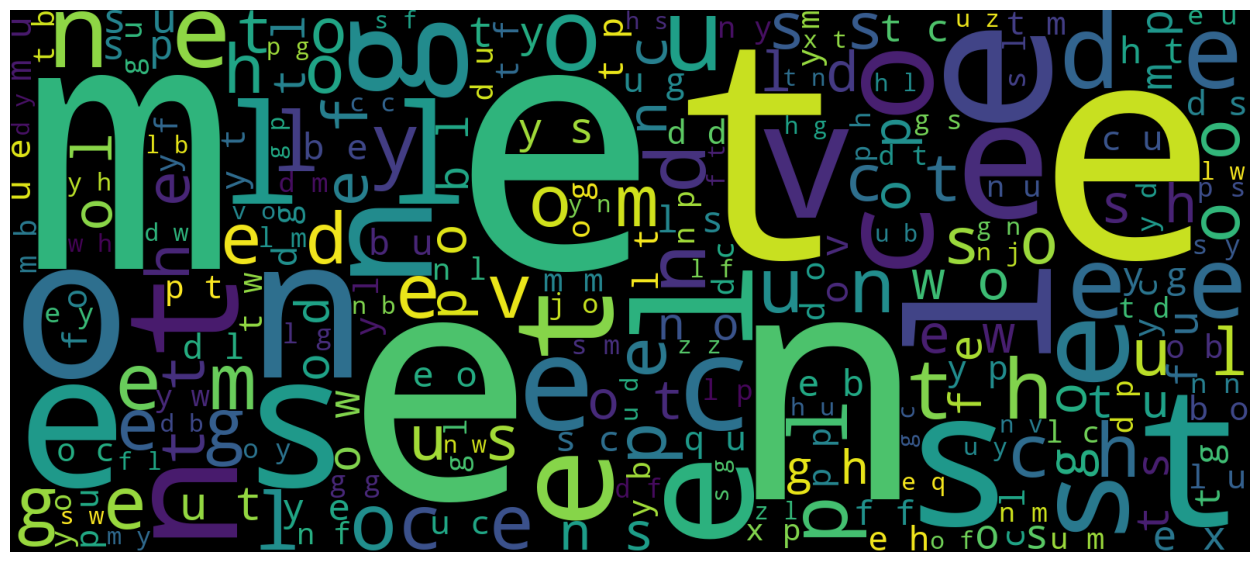

In [56]:
subplots(figsize=(16, 16))
imshow(X=WordCloud(random_state=2023, height=700, width=1600 ).generate(text=' '.join(filtered_sentiment_lst), ))
axis('off')

### Tokens

- Distribution of key terms across all reviews

(-0.5, 1599.5, 699.5, -0.5)

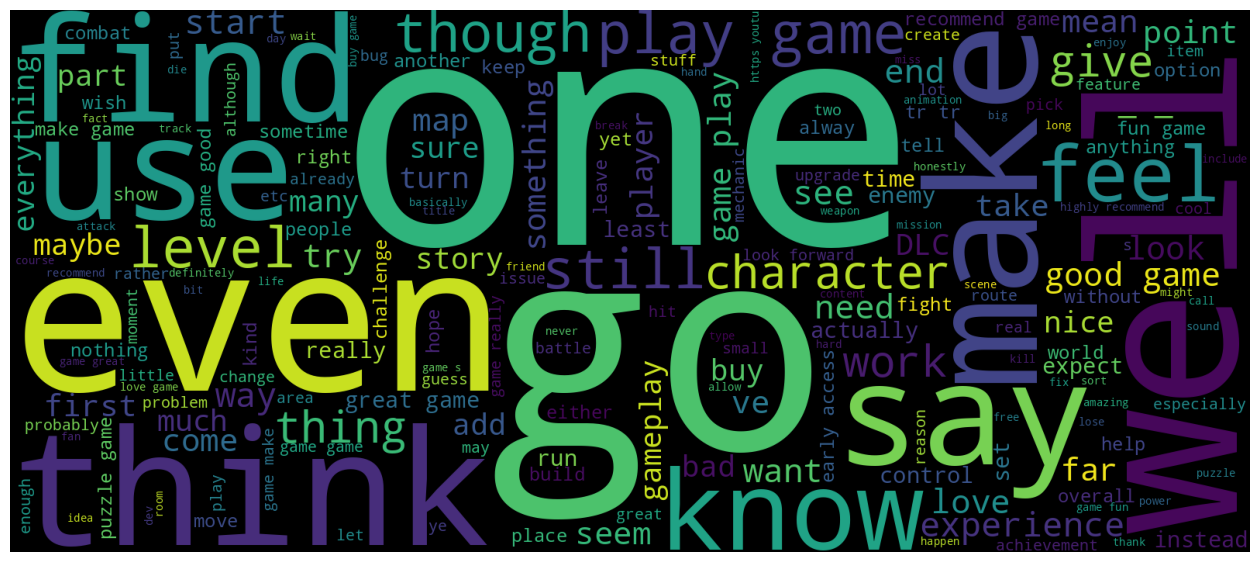

In [45]:
subplots(figsize=(16, 16))
imshow(X=WordCloud(random_state=2023, height=700, width=1600 ).generate(text=' '.join(filtered_lst), ))
axis('off')

## VADER Results

- Extracted sentiment vs. Recommendation

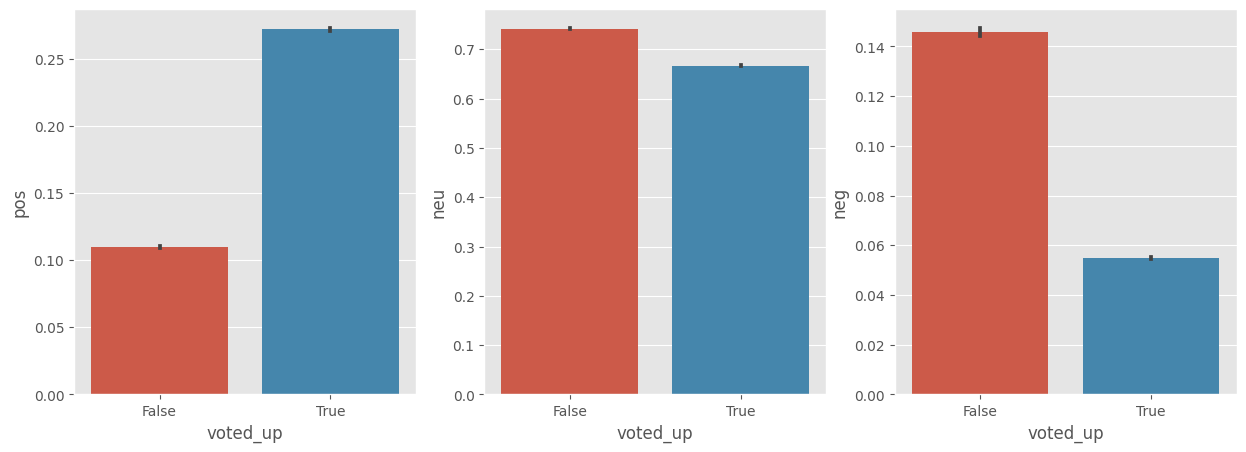

In [54]:
fig, axs = plt.subplots(1,3,figsize=(15,5))

sns.barplot(data=vaders, x='voted_up', y='pos', ax=axs[0])
sns.barplot(data=vaders, x='voted_up', y='neu', ax=axs[1])
sns.barplot(data=vaders, x='voted_up', y='neg', ax=axs[2])
plt.show()

## Top 5 Key-Terms per application

Halo 4


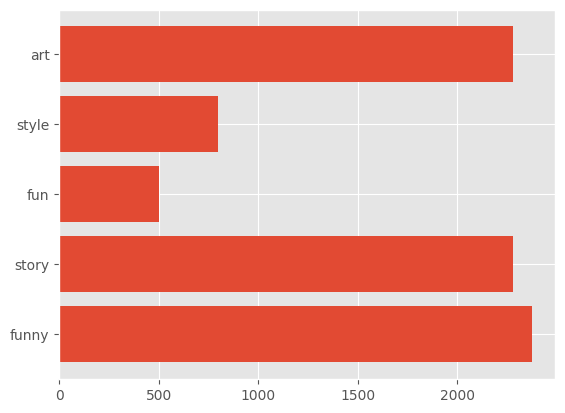

In [88]:
#manually input an application name
title = 'Halo 4'
top_terms = top_terms_per_topic[title]
print(title)
plt.barh(top_terms, mean_tfidf_scores)
plt.show()

Village Feud


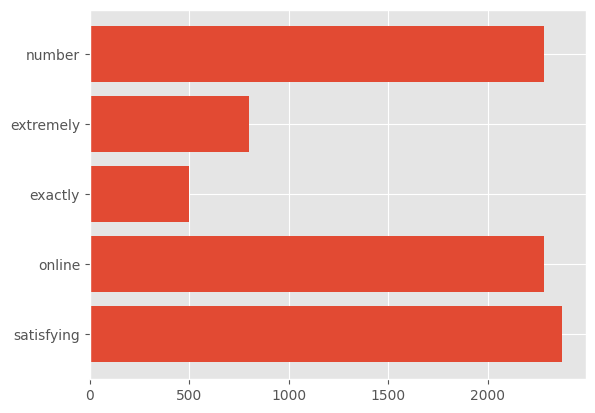

In [95]:
#choose an application at random
title = df_en['app_name'][np.random.randint(0, 189972)]
top_terms = top_terms_per_topic[title]
print(title)
plt.barh(top_terms, mean_tfidf_scores)
plt.show()